In [2]:
import gymnasium as gym
import gym_examples
import numpy as np
from copy import deepcopy, copy
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from MCTS.utils import render_rgb, action_arrow, opponent_random

In [3]:
env = gym.make('GridWorld-v0', render_mode='human')
env.reset()

({'agent': array([3, 4]), 'target': array([3, 1])}, {'distance': 3.0})

In [4]:
# assign step returns
observation, reward, terminated, truncated, info = env.step(3)
print(f'Observation: {observation}\nReward: {reward}\nTerminated: {terminated}\nTruncated: {truncated}\nInfo: {info}')
env.close()

Observation: {'agent': array([3, 3]), 'target': array([3, 1])}
Reward: 0
Terminated: False
Truncated: False
Info: {'distance': 2.0}


In [4]:
# Action space
print(f'Action space: {env.action_space}')

Action space: Discrete(4)


In [63]:
class REINFORCE_with_baseline():
    def __init__(self, env, state, step_horizon=1000, iter_budget=1000, gamma=0.9, alpha_theta=0.1, alpha_w=0.001):
        self.env = deepcopy(env)
        self.start_env = deepcopy(env)
        self.env_size = env.get_state_space_size()
        self.action_size = env.get_action_space_size()
        self.v = np.zeros(self.env_size)
        self.is_gridworld = isinstance(self.env_size, tuple)
        if (self.is_gridworld):
            self.theta = np.random.rand(self.env_size[0], self.env_size[1], self.action_size)
        else:
            self.theta = np.random.rand(self.env_size, self.action_size)
        
        self.pi = self._define_policy()
        if (self.is_gridworld):
            self.start_state = deepcopy(state['agent'])
            self.state = state['agent']
        else:
            self.start_state = state
            self.state = state
        
        self.step_horizon = step_horizon
        self.iter_budget = iter_budget
        self.gamma = gamma
        self.alpha_theta = alpha_theta
        self.alpha_w = alpha_w
        
    def _define_policy(self):
        return np.exp(self.theta)/np.sum(np.exp(self.theta), axis=-1, keepdims=True)
    
    def optimize(self):
        # Algorithm tracking variables
        iterations = 0
        rewards_list = []
        
        # Loops through algorithm until done
        while (iterations < self.iter_budget):
            iterations += 1                     # Tracks number of iterations
                
            states, actions, rewards = self.generate_episode()
            self.update_parameters(states, actions, rewards)   # Evaluates the current policy
            self.pi = self._define_policy()     # Improves the policy
            total_reward = np.dot(rewards, [self.gamma**k for k in range(len(rewards))])
            rewards_list.append(total_reward)

        return rewards_list
        
        
    def select_action(self):
        if (self.is_gridworld):
            return np.random.choice([a for a in range(len(self.pi[self.state[0], self.state[1]]))], p=self.pi[self.state[0], self.state[1]])
        else:
            available_actions = self.env.get_valid_moves()
            probabilities = [self.pi[self.state, a] for a in available_actions]
            return np.random.choice(available_actions, p=(probabilities/np.sum(probabilities)))
    
    def generate_episode(self):
        steps = 0
        states_visited = []
        actions_taken = []
        rewards = []
        if (self.is_gridworld):
            self.state = deepcopy(self.start_state)
        else:
            self.state = self.env.reset()
        terminated = False

        while (not terminated and steps <= self.step_horizon):
            steps += 1
            action = self.select_action()
            states_visited.append(self.state)
            actions_taken.append(action)
            if (self.is_gridworld):
                obs, reward, terminated, truncated, info = self.env.step(action)
                self.state = obs['agent']
            else:
                obs, reward, terminated, truncated, info = self.env.step((0, action))
                if (not terminated):
                    opp_action = np.random.choice(self.env.get_valid_moves())
                    obs, reward, terminated, truncated, info = self.env.step((1, opp_action))

                if (not terminated):
                    self.state = obs
            
            rewards.append(reward)

        return states_visited, actions_taken, rewards
    
    def update_parameters(self, states, actions, rewards):
        for t in range(len(states)):
            G = np.dot(rewards[t:], [self.gamma**k for k in range(len(states) - t)])

            if (self.is_gridworld):
                delta = G - self.v[states[t][0], states[t][1]]
                self.v[states[t][0], states[t][1]] += self.alpha_w * delta
                self.theta[states[t][0], states[t][1]] -= self.alpha_theta * self.gamma**t * delta * self.pi[states[t][0], states[t][1]]
                self.theta[states[t][0], states[t][1], actions[t]] += self.alpha_theta * self.gamma**t * delta
            else:
                delta = G - self.v[states[t]]
                self.v[states[t]] += self.alpha_w * delta
                self.theta[states[t]] -= self.alpha_theta * self.gamma**t * delta * self.pi[states[t]]
                self.theta[states[t], actions[t]] += self.alpha_theta * self.gamma**t * delta

## GridWorld Environment

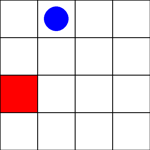

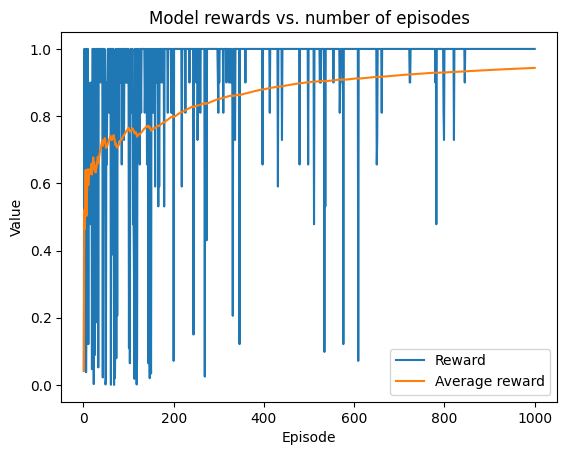

In [6]:
# run MCTS on the environment
env = gym.make('GridWorld-v0', render_mode='rgb_array', size=4)
obs, info = env.reset()
render_rgb(env.render())

# Optimize the model for this environment
model = REINFORCE_with_baseline(env, obs)
rewards = model.optimize()
average_rewards = [np.sum(rewards[:t+1])/(t+1) for t in range(len(rewards))]

plt.plot([i+1 for i in range(len(rewards))], rewards, label='Reward')
plt.plot([i+1 for i in range(len(rewards))], average_rewards, label='Average reward')
plt.title('Model rewards vs. number of episodes')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.show()

# Run one episode
# total_reward = run_Gridworld_episode(env, obs, print_depth=3)
# print(f'Total reward: {total_reward}')

## Tic-Tac-Toe Environment

In [27]:
ttt_env = gym.make('tictactoe-v0') 
ttt_env.reset()
print(ttt_env.get_valid_moves())
print(ttt_env.step((0,1)))
ttt_env.render()
print(ttt_env.step((1,1)))
ttt_env.render()

[0, 1, 2, 3, 4, 5, 6, 7, 8]
(3, 0, False, False, {'info': 'normal move player 1'})
| |O| |
| | | |
| | | |

(3, 0, False, False, {'info': 'invalid move player 2'})
| |O| |
| | | |
| | | |



Agent (player 1): O  
Random opponent (player 2): X

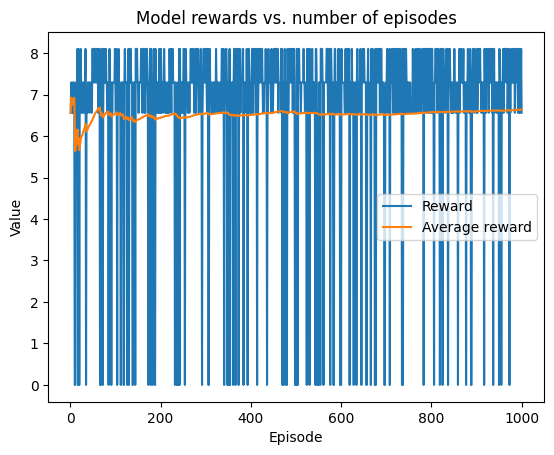

In [67]:
obs = ttt_env.reset()

# Optimize the model for this environment
model = REINFORCE_with_baseline(ttt_env, obs)
rewards = model.optimize()
average_rewards = [np.sum(rewards[:t+1])/(t+1) for t in range(len(rewards))]

plt.plot([i+1 for i in range(len(rewards))], rewards, label='Reward')
plt.plot([i+1 for i in range(len(rewards))], average_rewards, label='Average reward')
plt.title('Model rewards vs. number of episodes')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.show()